##### **Library Import**

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rn
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D,  BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping 

##### **Preprocessing Data**

In [3]:
# path dataset
train_data_dir = "./dataset/Plants/train"
val_data_dir = "./dataset/Plants/val"
test_data_dir = "./dataset/Plants/test"

# data configuration
img_size = (224, 224)
batch_size = 32
epoch = 10
num_classes = 6

In [4]:
# data augmentation 
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
)

val_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

In [5]:
# create dataset generator
train_dataset = train_data_generator.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    color_mode = 'rgb'
)
val_dataset = val_data_generator.flow_from_directory(
    val_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode = 'rgb'
)
test_dataset = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode = 'rgb'
)

Found 2847 images belonging to 6 classes.
Found 746 images belonging to 6 classes.
Found 173 images belonging to 6 classes.


In [6]:
# displays samples data
def show_image_samples(gen):
    # ensure generator has class_indices attribute
    if hasattr(gen, 'class_indices'):
        test_dict = gen.class_indices
        classes = list(test_dict.keys())
    else:
        raise AttributeError("The provided generator does not have 'class_indices' attribute.")
    
    images, labels = next(gen)  
    plt.figure(figsize=(20, 20))
    length = len(labels)
    r = min(length, 25)  
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = images[i]
        plt.imshow(image, cmap='gray')
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, fontsize=16)
        plt.axis('off')
    plt.show()

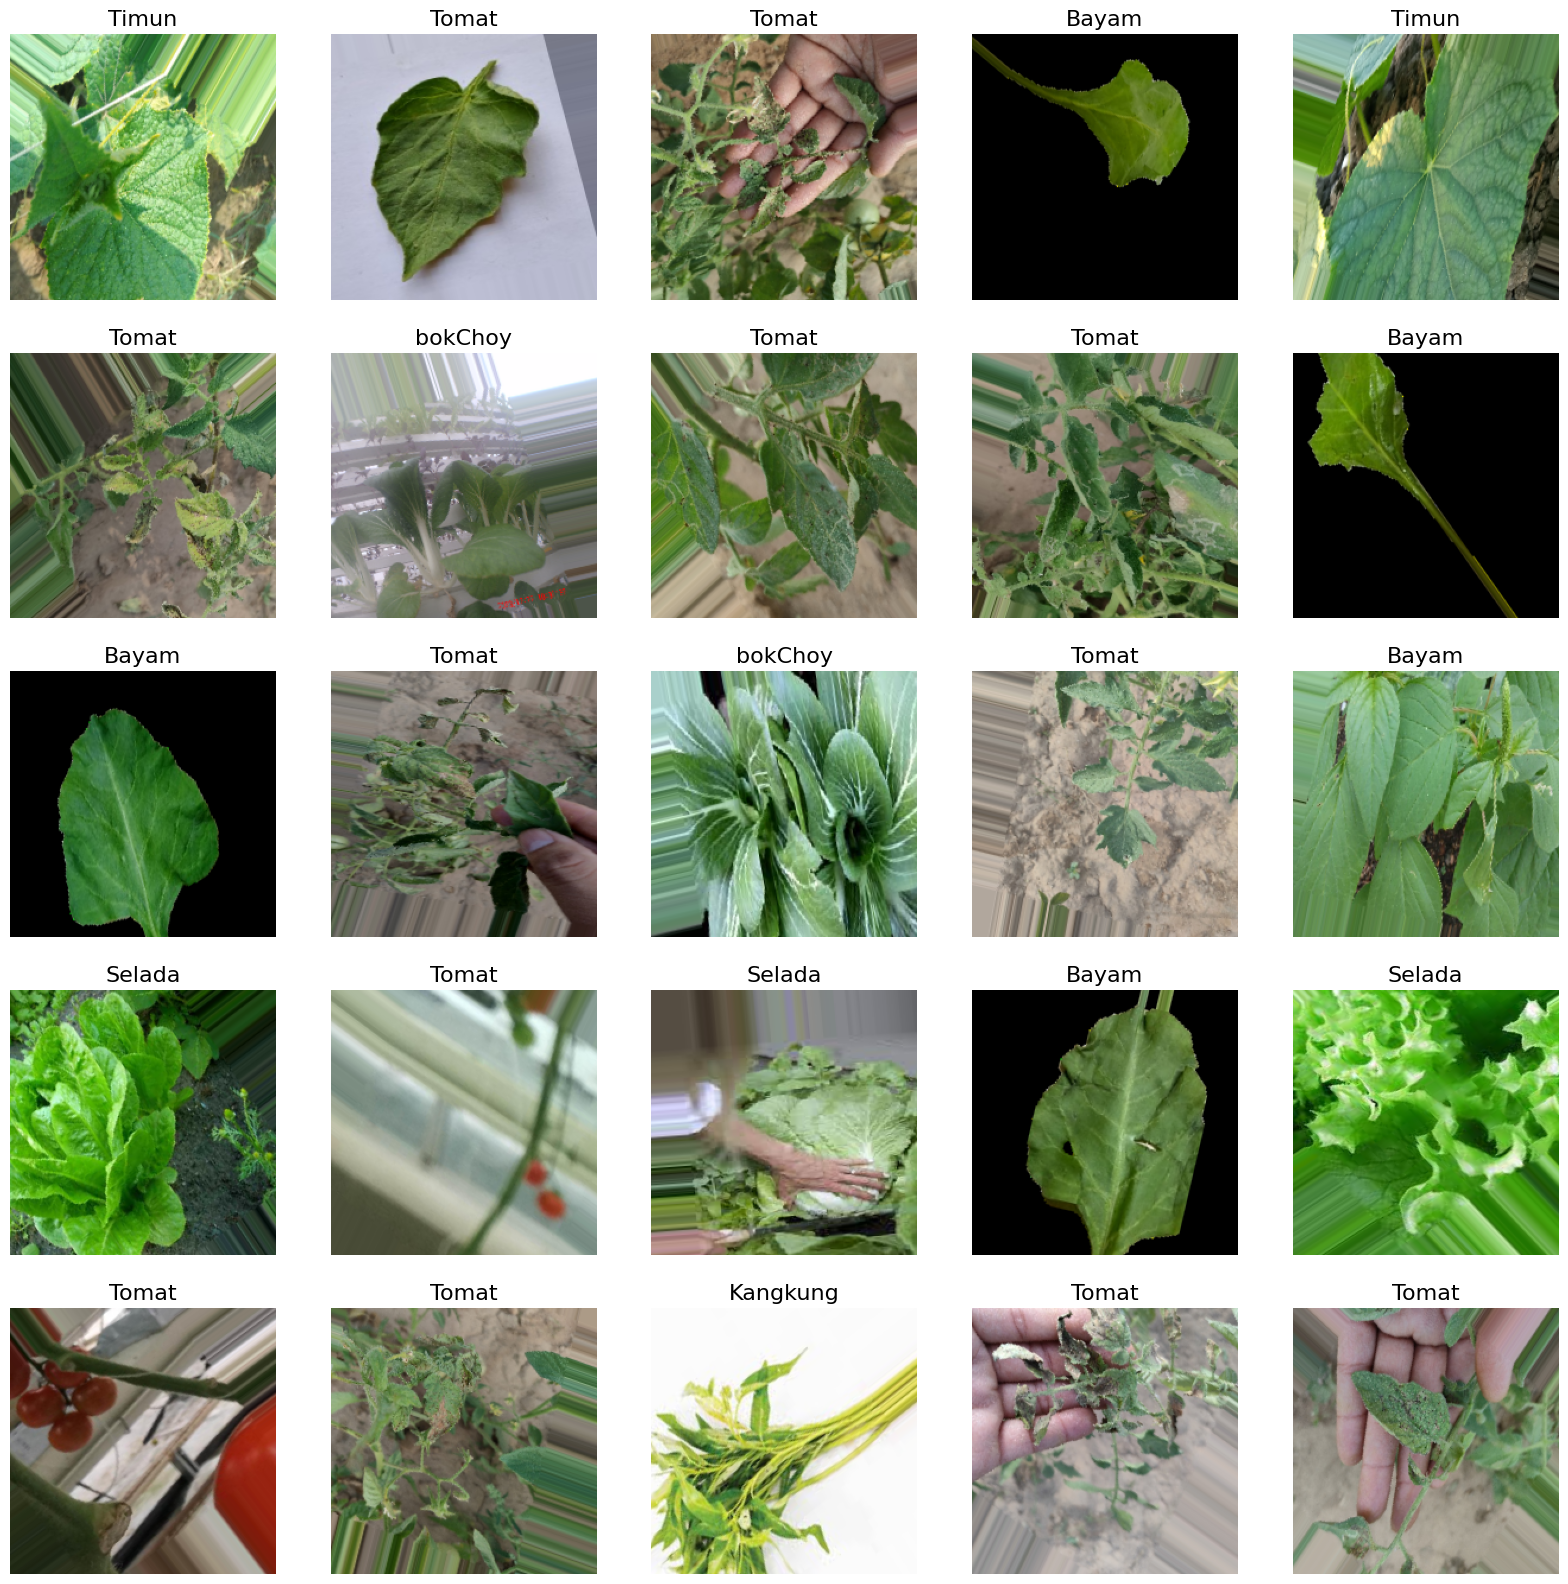

In [7]:
show_image_samples(train_dataset)

In [8]:
# create plant label table 
df_labels = pd.DataFrame(list(train_dataset.class_indices.keys()), columns=['Nama Tanaman'])
df_labels['Class'] = list(train_dataset.class_indices.values())

df_labels

Nama Tanaman  Class
0        Bayam      0
1     Kangkung      1
2       Selada      2
3        Timun      3
4        Tomat      4
5      bokChoy      5

In [9]:
classes_name = list(train_dataset.class_indices.keys())
classes_name

['Bayam', 'Kangkung', 'Selada', 'Timun', 'Tomat', 'bokChoy']

Text(0.5, 1.0, 'Class: Timun')

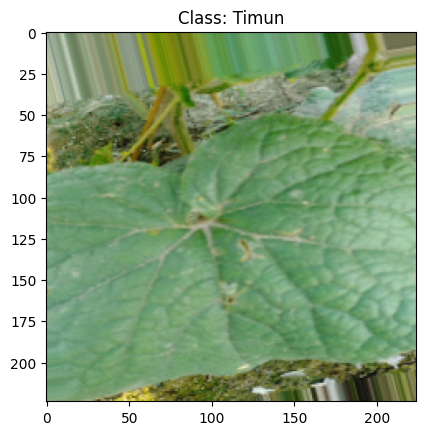

In [10]:
# batch generator access -> one image in one batch
img, label = next(train_dataset)
plt.imshow(img[0])
plt.title(f"Class: {classes_name[np.argmax(label[0])]}")

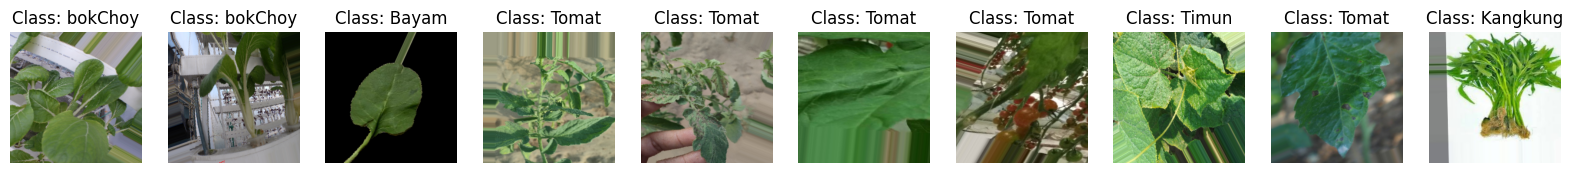

In [11]:
# batch generator access -> multiple images in one batch
img, label = next(train_dataset)  
plt.figure(figsize=(20, 10))  
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(img[i])  
    plt.title(f"Class: {classes_name[np.argmax(label[i])]}")
    plt.axis('off')

plt.show()

##### **Building Model**

In [12]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [13]:
from tensorflow.keras.regularizers import l2

# add additional layers for classification
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),  
    BatchNormalization(),
    Dropout(0.4),  
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),  
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,048,774 (11.63 MB)

 Trainable params: 789,766 (3.01 MB)

 Non-trainable params: 2,259,008 (8.62 MB)

##### **Evaluation**

In [14]:
# model compilation
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# reduceLROnPlateau callback to adjust learning rate dynamically
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# training model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,  
    callbacks=[early_stop, reduce_lr]
)

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 75s 799ms/step - accuracy: 0.3497 - loss: 3.3081 - val_accuracy: 0.8673 - val_loss: 1.5798 - learning_rate: 1.0000e-04
Epoch 2/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 65s 731ms/step - accuracy: 0.7864 - loss: 1.7147 - val_accuracy: 0.8981 - val_loss: 1.4230 - learning_rate: 1.0000e-04
Epoch 3/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 66s 746ms/step - accuracy: 0.8651 - loss: 1.4889 - val_accuracy: 0.9075 - val_loss: 1.3963 - learning_rate: 1.0000e-04
Epoch 4/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 65s 733ms/step - accuracy: 0.9045 - loss: 1.3687 - val_accuracy: 0.9102 - val_loss: 1.3975 - learning_rate: 1.0000e-04
Epoch 5/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 65s 733ms/step - accuracy: 0.9088 - loss: 1.3107 - val_accuracy: 0.9075 - val_loss: 1.4202 - learning_rate: 1.0000e-04
Epoch 6/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.9177 - loss: 1.2832
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
89/89 ━━━━━━━━━━━━━━━━━━━━ 66s 735ms/step - accuracy:

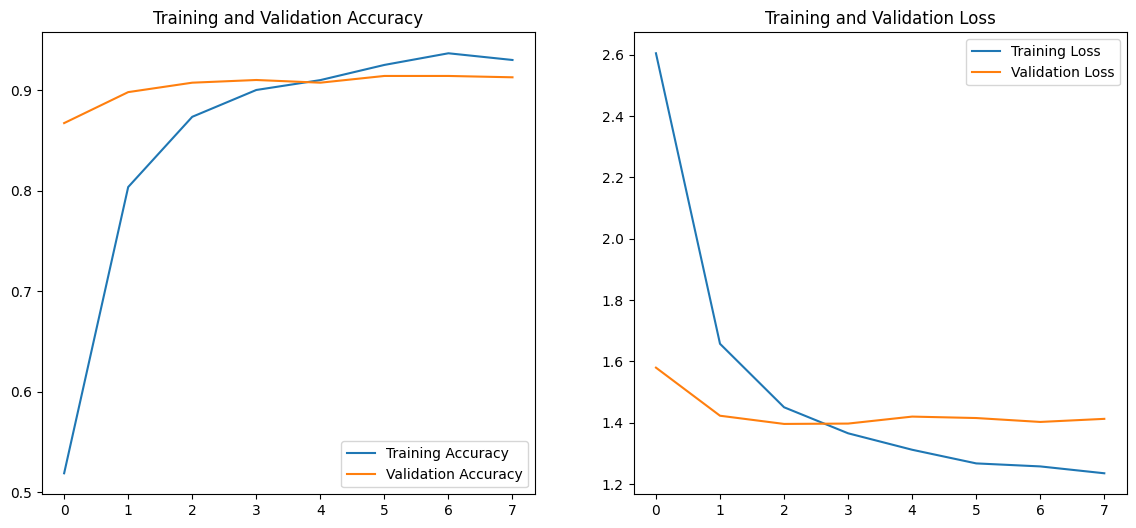

In [15]:
# accuracy and loss plot
def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_metrics(history)

In [16]:
# evaluation tes dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 400ms/step - accuracy: 0.9524 - loss: 1.1394
Test Accuracy: 94.22%
Test Loss: 1.1626


In [17]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# prediction on single image
def predict_single_image(image_path, model, classes):
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    pred_class = classes[np.argmax(pred)]
    confidence = np.max(pred) * 100

    plt.imshow(img)
    plt.title(f"Prediction: {pred_class} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

In [18]:
y_pred = model.predict(test_dataset)
y_pred = np.argmax(y_pred, axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step


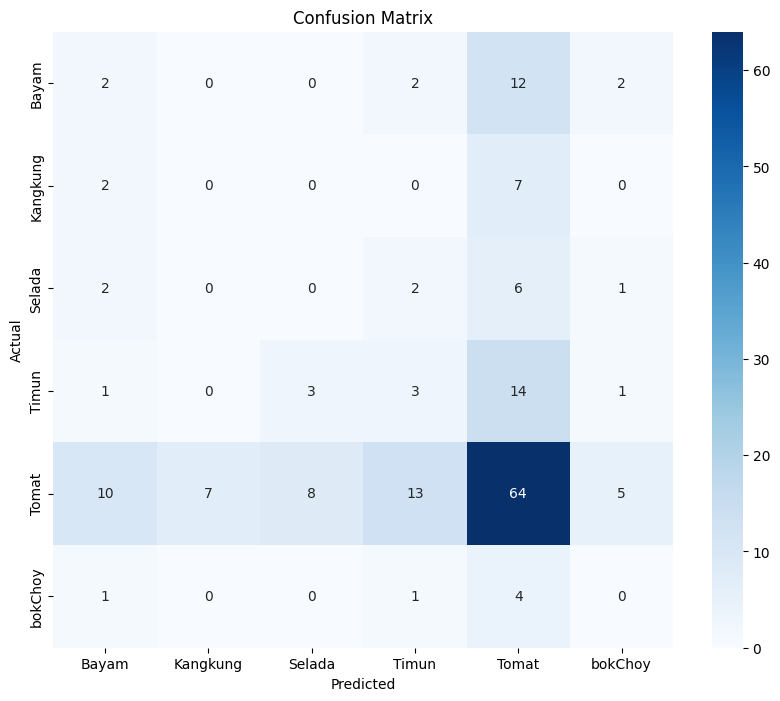

In [19]:
cm = confusion_matrix(test_dataset.classes, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=classes_name, yticklabels=classes_name)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


##### **Testing Test Data**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step


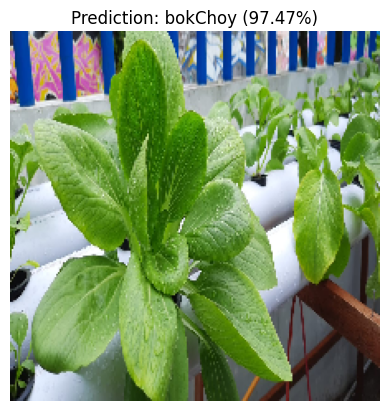

In [20]:
sample_image_path = 'D:/caps/Machine-Learning/dataset/Plants/test/bokChoy/WhatsApp_Image_2021-12-29_at_10_02_37 (1).jpeg'
predict_single_image(sample_image_path, model, classes_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


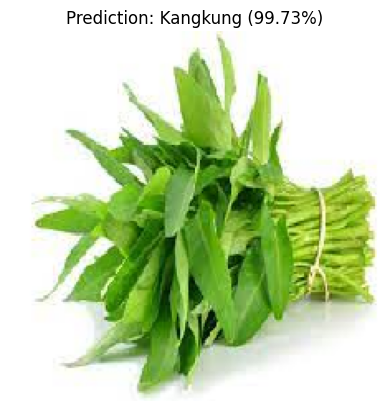

In [21]:
sample_image_path = 'D:/caps/Machine-Learning/dataset/Plants/test/Kangkung/KALE 3.jpg'
predict_single_image(sample_image_path, model, classes_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


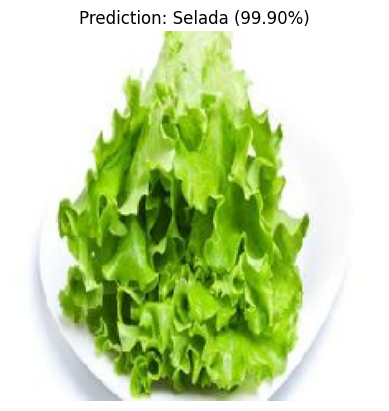

In [22]:
sample_image_path = 'D:/caps/Machine-Learning/dataset/Plants/test/Selada/SELADA (153).jpg'
predict_single_image(sample_image_path, model, classes_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


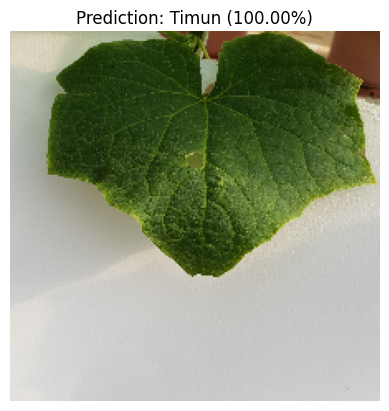

In [23]:
sample_image_path = 'D:/caps/Machine-Learning/dataset/Plants/test/Timun/O_Unhealthy_20210208_104025.jpg'
predict_single_image(sample_image_path, model, classes_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


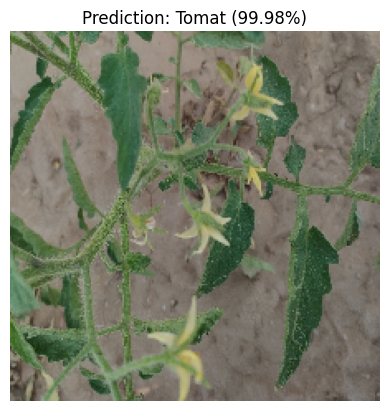

In [24]:
sample_image_path = 'D:/caps/Machine-Learning/dataset/Plants/test/Tomat/IMG20220323081507_aug7.jpg'
predict_single_image(sample_image_path, model, classes_name)

##### **Testing New Data**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


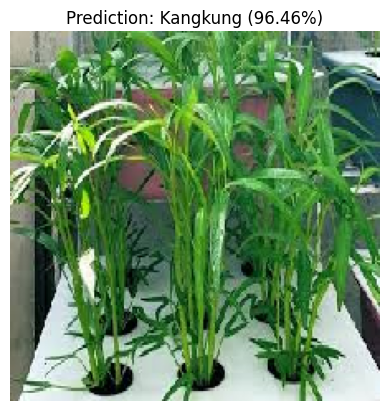

In [25]:
sample_image_path = 'D:/caps/Machine-Learning/dataset/NewImages/ni_kangkung.jpeg'
predict_single_image(sample_image_path, model, classes_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


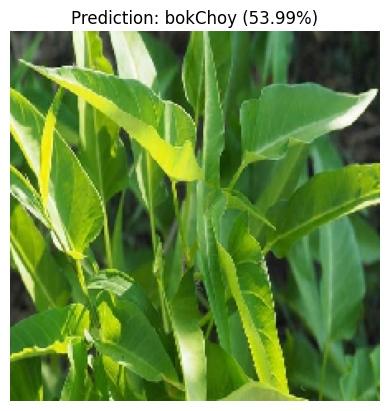

In [26]:
sample_image_path = 'D:/caps/Machine-Learning/dataset/NewImages/ni_kangkung2.jpg'
predict_single_image(sample_image_path, model, classes_name)

In [27]:
model.save('plants_mobileNetV2.keras')